# Pre processing of InkML dataset

https://github.com/RobinXL/inkml2img

https://github.com/ThomasLech/CROHME_extractor

https://github.com/bachelor10/recurrent-octo-sniffle

Intention is to find a way to convert InkML files to images, but maintain some size normalisation

this might be useful!

https://sujayr91.github.io/Im2Latex/

In [3]:
import numpy as np
from skimage.draw import line
from skimage.morphology import thin
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from io import StringIO

# InkML to IMG

based on https://github.com/RobinXL/inkml2img

In [4]:
def get_traces_data(inkml_file_abs_path, xmlns='{http://www.w3.org/2003/InkML}'):

    	traces_data = []

    	tree = ET.parse(inkml_file_abs_path)
    	root = tree.getroot()
    	# doc_namespace = "{http://www.w3.org/2003/InkML}"
    	doc_namespace = xmlns

    	'Stores traces_all with their corresponding id'
    	traces_all = [{'id': trace_tag.get('id'),
    					'coords': [[round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000) \
    									for axis_coord in coord[1:].split(' ')] if coord.startswith(' ') \
    								else [round(float(axis_coord)) if float(axis_coord).is_integer() else round(float(axis_coord) * 10000) \
    									for axis_coord in coord.split(' ')] \
    							for coord in (trace_tag.text).replace('\n', '').split(',')]} \
    							for trace_tag in root.findall(doc_namespace + 'trace')]

    	'Sort traces_all list by id to make searching for references faster'
    	traces_all.sort(key=lambda trace_dict: int(trace_dict['id']))

    	'Always 1st traceGroup is a redundant wrapper'
    	traceGroupWrapper = root.find(doc_namespace + 'traceGroup')

    	if traceGroupWrapper is not None:
    		for traceGroup in traceGroupWrapper.findall(doc_namespace + 'traceGroup'):

    			label = traceGroup.find(doc_namespace + 'annotation').text

    			'traces of the current traceGroup'
    			traces_curr = []
    			for traceView in traceGroup.findall(doc_namespace + 'traceView'):

    				'Id reference to specific trace tag corresponding to currently considered label'
    				traceDataRef = int(traceView.get('traceDataRef'))

    				'Each trace is represented by a list of coordinates to connect'
    				single_trace = traces_all[traceDataRef]['coords']
    				traces_curr.append(single_trace)


    			traces_data.append({'label': label, 'trace_group': traces_curr})

    	else:
    		'Consider Validation data that has no labels'
    		[traces_data.append({'trace_group': [trace['coords']]}) for trace in traces_all]

    	return traces_data

In [5]:
def convert_to_imgs(traces_data, box_size=int(100)):

        patterns_enc = []
        classes_rejected = []

        for pattern in traces_data:

            trace_group = pattern['trace_group']

            'mid coords needed to shift the pattern'
            min_x, min_y, max_x, max_y = get_min_coords(trace_group)

            'traceGroup dimensions'
            trace_grp_height, trace_grp_width = max_y - min_y, max_x - min_x

            'shift pattern to its relative position'
            shifted_trace_grp = shift_trace_grp(trace_group, min_x=min_x, min_y=min_y)

            'Interpolates a pattern so that it fits into a box with specified size'
            'method: LINEAR INTERPOLATION'
            try:
            	interpolated_trace_grp = interpolate(shifted_trace_grp, \
            										 trace_grp_height=trace_grp_height, trace_grp_width=trace_grp_width, box_size=box_size - 1)
            except Exception as e:
            	print(e)
            	print('This data is corrupted - skipping.')
            	classes_rejected.append(pattern.get('label'))

            	continue

            'Get min, max coords once again in order to center scaled patter inside the box'
            min_x, min_y, max_x, max_y = get_min_coords(interpolated_trace_grp)

            centered_trace_grp = center_pattern(interpolated_trace_grp, max_x=max_x, max_y=max_y, box_size=box_size)

            'Center scaled pattern so it fits a box with specified size'
            pattern_drawn = draw_pattern(centered_trace_grp, box_size=box_size)
            # Make sure that patterns are thinned (1 pixel thick)
            pat_thinned = 1.0 - thin(1.0 - np.asarray(pattern_drawn))
            plt.imshow(pat_thinned, cmap='gray')
            plt.show()
            pattern_enc = dict({'features': pat_thinned, 'label': pattern.get('label')})

            # Filter classes that belong to categories selected by the user
#             if pattern_enc.get('label') in self.classes:

            patterns_enc.append(pattern_enc)

        return patterns_enc, classes_rejected

In [6]:
def get_min_coords(trace_group):

    	min_x_coords = []
    	min_y_coords = []
    	max_x_coords = []
    	max_y_coords = []

    	for trace in trace_group:

    		x_coords = [coord[0] for coord in trace]
    		y_coords = [coord[1] for coord in trace]

    		min_x_coords.append(min(x_coords))
    		min_y_coords.append(min(y_coords))
    		max_x_coords.append(max(x_coords))
    		max_y_coords.append(max(y_coords))

    	return min(min_x_coords), min(min_y_coords), max(max_x_coords), max(max_y_coords)

In [7]:
def shift_trace_grp(trace_group, min_x, min_y):

    	shifted_trace_grp = []

    	for trace in trace_group:
    		shifted_trace = [[coord[0] - min_x, coord[1] - min_y] for coord in trace]

    		shifted_trace_grp.append(shifted_trace)

    	return shifted_trace_grp

def interpolate(trace_group, trace_grp_height, trace_grp_width, box_size):

    	interpolated_trace_grp = []

    	if trace_grp_height == 0:
    		trace_grp_height += 1
    	if trace_grp_width == 0:
    		trace_grp_width += 1

    	'' 'KEEP original size ratio' ''
    	trace_grp_ratio = (trace_grp_width) / (trace_grp_height)

    	scale_factor = 1.0
    	'' 'Set \"rescale coefficient\" magnitude' ''
    	if trace_grp_ratio < 1.0:

    		scale_factor = (box_size / trace_grp_height)
    	else:

    		scale_factor = (box_size / trace_grp_width)

    	for trace in trace_group:
    		'coordintes convertion to int type necessary'
    		interpolated_trace = [[round(coord[0] * scale_factor), round(coord[1] * scale_factor)] for coord in trace]

    		interpolated_trace_grp.append(interpolated_trace)

    	return interpolated_trace_grp


In [8]:
def get_min_coords(trace_group):

    	min_x_coords = []
    	min_y_coords = []
    	max_x_coords = []
    	max_y_coords = []

    	for trace in trace_group:

    		x_coords = [coord[0] for coord in trace]
    		y_coords = [coord[1] for coord in trace]

    		min_x_coords.append(min(x_coords))
    		min_y_coords.append(min(y_coords))
    		max_x_coords.append(max(x_coords))
    		max_y_coords.append(max(y_coords))

    	return min(min_x_coords), min(min_y_coords), max(max_x_coords), max(max_y_coords)
def center_pattern(trace_group, max_x, max_y, box_size):

    	x_margin = int((box_size - max_x) / 2)
    	y_margin = int((box_size - max_y) / 2)

    	return shift_trace_grp(trace_group, min_x= -x_margin, min_y= -y_margin)

In [9]:
def draw_pattern(trace_group, box_size):

    	pattern_drawn = np.ones(shape=(box_size, box_size), dtype=np.float32)
    	for trace in trace_group:

    		' SINGLE POINT TO DRAW '
    		if len(trace) == 1:
    			x_coord = trace[0][0]
    			y_coord = trace[0][1]
    			pattern_drawn[y_coord, x_coord] = 0.0

    		else:
    			' TRACE HAS MORE THAN 1 POINT '

    			'Iterate through list of traces endpoints'
    			for pt_idx in range(len(trace) - 1):
    				print (pt_idx, trace[pt_idx])

    				'Indices of pixels that belong to the line. May be used to directly index into an array'
    				pattern_drawn[line(r0=int(trace[pt_idx][1]), c0=int(trace[pt_idx][0]),
    								   r1=int(trace[pt_idx + 1][1]), c1=int(trace[pt_idx + 1][0]))] = 0

    	return pattern_drawn

In [10]:
def inkml2img(input_path, output_path, color='black'):
    traces = get_traces_data(input_path)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)
    plt.axes().spines['top'].set_visible(False)
    plt.axes().spines['right'].set_visible(False)
    plt.axes().spines['bottom'].set_visible(False)
    plt.axes().spines['left'].set_visible(False)
    for elem in traces:
        ls = elem['trace_group']
        for subls in ls:
            data = np.array(subls)
            x,y=zip(*data)
            plt.plot(x,y,linewidth=2,c=color)
    plt.savefig(output_path, bbox_inches='tight', dpi=100)
    plt.gcf().clear()

### The Main Method

In [1]:
inputpath = 'CROHME_extractor/data/CROHME_full_v2/CROHME2011_data/CROHME_training/formulaire001-equation001.inkml'
outputpath = 'generatedimgs/test1.png'

In [2]:
inkml2img(inputpath, outputpath, color='#284054')

NameError: name 'inkml2img' is not defined

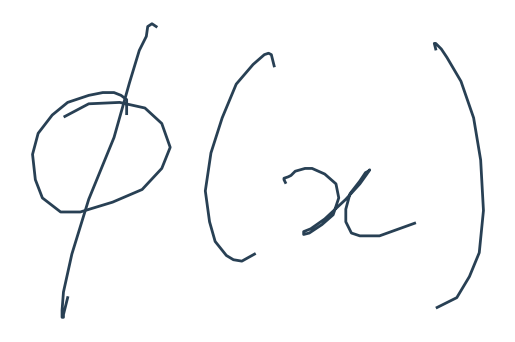

In [3]:
from IPython.display import Image
Image(filename=outputpath)

# Segmentation

Adding boxes around each character

Done using OpenCV

Several steps:

-grayscale

-smooth img

-adaptive threshold(?)

-dialation and erosion(?)

-contours

for presentation, maybe can render these lor


https://stackoverflow.com/questions/10964226/how-to-convert-an-image-into-character-segments

https://github.com/quangnhat185/Plate_detect_and_recognize

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from local_utils import detect_lp
from os.path import splitext, basename
from keras.models import model_from_json
import glob
import IPython
#print(IPython.sys_info())
%matplotlib inline
from matplotlib import gridspec

In [5]:
outputpath = 'generatedimgs/test1.png'

# Load the image
img = cv2.imread(outputpath)

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

cv2.imshow('graycsale image',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

#no change actually hahaa

In [6]:
# smooth the image to avoid noises
gray = cv2.medianBlur(gray,5)

cv2.imshow('smoothed image',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

<div>
<img src = 'generatedimgs/blur1.png', width="300"/>
</div>

In [12]:
# apply some dilation and erosion to join the gaps
thresh = cv2.dilate(gray,None,iterations = 5)

cv2.imshow('dilation',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
# apply some dilation and erosion to join the gaps

thresh = cv2.erode(thresh,None,iterations = 5)

cv2.imshow('erosion',thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(gray,255,1,1,11,2)
thresh_color = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

cv2.imshow('thresh',thresh_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

<div>
<img src = 'generatedimgs/thres1.png', width="300"/>
</div>

In [32]:
# apply some dilation and erosion to join the gaps
thresh = cv2.dilate(thresh,None,iterations = 5)
thresh = cv2.erode(thresh,None,iterations = 5)

cv2.imshow('thresh',thresh_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

img_nobox = thresh_color.copy()

<div>
<img src = 'generatedimgs/dilation1.png', width="300"/>
</div>

In [33]:
# Find the contours
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

digitCnts = []

# For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.rectangle(thresh_color,(x,y),(x+w,y+h),(0,255,0),2)
    
    ## if the contour is sufficiently large, it must be a digit
    if w >= 15:
        digitCnts.append(cnt)
        
img_wbox = thresh_color.copy()

# Finally show the image
cv2.imshow('img',img)
cv2.imshow('res',thresh_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [34]:
# #saving segmented files locally
# cv2.imwrite('generatedimgs/segmentedtest1.png', img)

# Trying to get the right characters segmented

It creates new windows, but it appears as such:
<div>
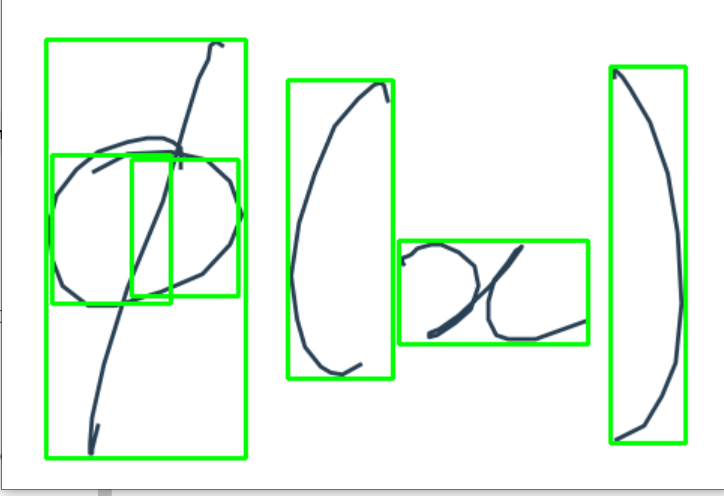
</div>

Or can try using Sobel operation to adapt so that it can be used for any image (can be tilted, on a whiteboard etc)

## Non Maximum Supression

So its ok now, succeeded and able to draw rectangles properly.

But based on Prof Loke's advice, should not need to manually remove.

Going to try **Non Maximum Supression**

-  is a class of algorithms to select one entity (e.g., bounding boxes) out of many overlapping entities
- taken from https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

In [35]:
#boxes is a numpy array of (x,y,w,h)
#eg np.array([
# 	(12, 30, 76, 94),
# 	(12, 36, 76, 100),
# 	(72, 36, 200, 164),
# 	(84, 48, 212, 176)])

In [12]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [37]:
# Find the contours
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

digitCnts = []
boxes = []

# For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    print(x,y,x+w,y+h)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    digitCnts.append(cnt)
    
    boxes.append(np.array([x,y,x+w,y+h]))

283 167 415 238
92 107 167 204
34 104 120 211
204 52 276 263
433 42 485 309
31 23 171 319


In [38]:
print(len(digitCnts))
print(digitCnts[0].shape)

6
(222, 1, 2)


In [39]:
print(boxes)

[array([283, 167, 415, 238]), array([ 92, 107, 167, 204]), array([ 34, 104, 120, 211]), array([204,  52, 276, 263]), array([433,  42, 485, 309]), array([ 31,  23, 171, 319])]


In [40]:
a1,a2,a3,a4,a5,a6 = boxes

for i in range(len(boxes)):
    newarray = np.stack(boxes, axis=0, out=None)

In [41]:
print(newarray)

[[283 167 415 238]
 [ 92 107 167 204]
 [ 34 104 120 211]
 [204  52 276 263]
 [433  42 485 309]
 [ 31  23 171 319]]


In [42]:
for cnt in digitCnts:    
    x,y,w,h = cv2.boundingRect(cnt)
    # perform non-maximum suppression on the bounding boxes
    pick = non_max_suppression_fast(newarray, 0.3)

print("after applying non-maximum," + str((len(pick))) + "bounding boxes")

after applying non-maximum,4bounding boxes


In [43]:
img_original = img_nobox.copy()
img_nms = img_nobox.copy()

In [44]:
for (startX, startY, endX, endY) in pick:
    cv2.rectangle(img_nms, (startX, startY), (endX, endY), (0, 255, 0), 2)

In [45]:
# # display the images
# cv2.imshow("Original Image", img_original)
# cv2.imshow("Original Segmentation", img_wbox)
#cv2.imshow("After NMS", img_nms)
#cv2.waitKey(0)

yay!:) 

Managed to remove overlapped boxes algorithmically, and received following comparative output:

<div>
<img src="generatedimgs/nmsprogress.png" width="300"/>
</div>

<div>
<img src="generatedimgs/correctsegmentation.png" width="300"/>
</div>

In [46]:
# #convert digitCnts to np array

# digitCnts = np.array(digitCnts)
# print(digitCnts.shape)

## [IGNORE] Removing Manually

Note: Determining the appropriate width and height constraints requires a few rounds of trial and error. I would suggest looping over each of the contours, drawing them individually, and inspecting their dimensions. Doing this process ensures you can find commonalities across digit contour properties

By observation, if it takes up enough space, it should be correctly identified.

So the criteria becomes either w>100 or x>100 bah in this case, trial and error one

**This is NOT preferable compared to NMS, so the following section of code can be, rather safely, ignored.**

In [47]:
# #redo the process to avoid overlap
# outputpath = 'generatedimgs/test1.png'

# # Load the image
# img2 = cv2.imread(outputpath)

# # convert to grayscale
# gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
# # smooth the image to avoid noises
# gray = cv2.medianBlur(gray,5)

# # Apply adaptive threshold
# thresh = cv2.adaptiveThreshold(gray,255,1,1,11,2)
# thresh_color2 = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

# # apply some dilation and erosion to join the gaps
# thresh = cv2.dilate(thresh,None,iterations = 5)
# thresh = cv2.erode(thresh,None,iterations = 5)

# # Find the contours
# contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

In [48]:
# # Find the contours
# contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

# # For each contour, find the bounding rectangle and draw it
# for cnt in contours:
#     x,y,w,h = cv2.boundingRect(cnt)
#     print(x,y,w,h)
#     #print("success")

In [49]:
# digitCnts = []

# # For each contour, find the bounding rectangle and draw it
# for cnt in contours:
#     x,y,w,h = cv2.boundingRect(cnt)
    
#     #syntax for cv2.rectangle: pass in top-left corner and bottom-right corner of rectangle
#     #then pass in colour of rectangle
#     #and thicknesS
       
#     if x>=100 or w >= 100 or h>150:
#         digitCnts.append(cnt)
        
#         cv2.rectangle(img2,(x,y),(x+w,y+h),(0,255,0),2)
#         cv2.rectangle(thresh_color2,(x,y),(x+w,y+h),(0,255,0),2)

# # Finally show the image
# cv2.imshow('img',img2)
# cv2.imshow('res',thresh_color2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Isolating each digit out

https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/



In [50]:
print(len(pick))

4


In [51]:
print(pick.shape)

(4, 4)


In [52]:
print(pick)

[[ 31  23 171 319]
 [433  42 485 309]
 [204  52 276 263]
 [283 167 415 238]]


In [60]:
print(type(pick))

pick2 = np.ndarray.tolist(pick)
print(type(pick2))

<class 'numpy.ndarray'>
<class 'list'>


In [64]:
print(digitCnts[0].shape)
print(newarray)

newarray2 = np.ndarray.tolist(newarray)

(222, 1, 2)
[[283 167 415 238]
 [ 92 107 167 204]
 [ 34 104 120 211]
 [204  52 276 263]
 [433  42 485 309]
 [ 31  23 171 319]]


In [74]:
filteredCntslist = []
a=0 #a is the index of the Cnt list that we are going to append to filtered Cnt list

for i in newarray2:
    for j in pick2:
        if i==j:
            print(i)
            print("a is " + str(a))
            filteredCntslist.append(digitCnts[a])
            print("len of filtered list is " + str(len(filteredCntslist)))
            
    a+=1

[283, 167, 415, 238]
a is 0
len of filtered list is 1
[204, 52, 276, 263]
a is 3
len of filtered list is 2
[433, 42, 485, 309]
a is 4
len of filtered list is 3
[31, 23, 171, 319]
a is 5
len of filtered list is 4


So now the cnts that are in the filteredCntlist, can now put that into the sortCnt function

# Sorting Characters Detected L to R

need to sort the digits from left to right, just to make sure

We’ll be using imutils, a series of convenience functions to make working with OpenCV + Python easier

https://github.com/jrosebr1/imutils

https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/

In [76]:
print(pick2)
newpick = pick2

[[31, 23, 171, 319], [433, 42, 485, 309], [204, 52, 276, 263], [283, 167, 415, 238]]


In [77]:
# loop over each of the digits
roilist = []

for i in newpick:
    #print(i)
    # extract the digit ROI
    x = i[0]
    y = i[1]
    w = i[2]
    h = i[3]
    
    print(x,y,w,h)   
    
    roi = thresh[y:h, x:w]
    roilist.append(roi)
    
    print(type(roi))
    print(roi.shape)

31 23 171 319
<class 'numpy.ndarray'>
(296, 140)
433 42 485 309
<class 'numpy.ndarray'>
(267, 52)
204 52 276 263
<class 'numpy.ndarray'>
(211, 72)
283 167 415 238
<class 'numpy.ndarray'>
(71, 132)


In [78]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [168]:
##FAILED ATTEMPT TO PATCH LIBRARY --IGNORE###

# # import the necessary packages
# import numpy as np
# import argparse
# import imutils
# import cv2
# def sort_contours(cnts, method="left-to-right"):
#     # initialize the reverse flag and sort index
#     reverse = False
#     i = 0
#     # handle if we need to sort in reverse
#     if method == "right-to-left" or method == "bottom-to-top":
#         reverse = True
#     # handle if we are sorting against the y-coordinate rather than
#     # the x-coordinate of the bounding box
#     if method == "top-to-bottom" or method == "bottom-to-top":
#         i = 1
#     # construct the list of bounding boxes and sort them from top to
#     # bottom
#     #boundingBoxes = [cv2.boundingRect(c) for c in cnts]
# #     boundingBoxes = []
# #     for (x,y,w,h) in cnts:
# #          boundingBoxes.append(cv2.rectangle(img,(x,y),(w,h),(0,255,0),2))
#     #boundingBoxes = [cv2.rectangle(img,(x,y),(w,h),(0,255,0),2) for (x,y,w,h) for c in cnts]
    
# #     (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
# #         key=lambda b:b[1][i], reverse=reverse))
    
#     cnts = sorted(zip(cnts), key=lambda x: x[0])
       
#     # return the list of sorted contours and bounding boxes
#     return cnts#, boundingBoxes)

In [80]:
# # sort the contours from left-to-right, then initialize the
# # actual digits themselves
newpick = sort_contours(filteredCntslist, method="left-to-right")[0]

In [82]:
print(len(newpick))

4


In [89]:
roilist = []

# loop over each of the digits
for c in newpick:
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    roi = thresh[y:y + h, x:x + w]
    roilist.append(roi)
    
    print(type(roi))
    print(roi.shape)
    
print(len(roilist))

<class 'numpy.ndarray'>
(296, 140)
<class 'numpy.ndarray'>
(211, 72)
<class 'numpy.ndarray'>
(71, 132)
<class 'numpy.ndarray'>
(267, 52)
4


# Compositing the Image into One Image

Composite photography is the use or combination of two or more different images to create a new one.


credit to https://www.geeksforgeeks.org/convert-a-numpy-array-to-an-image/ for PIL Image library

and some stackoverflow thread for the display() function

<class 'PIL.Image.Image'>


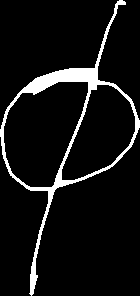

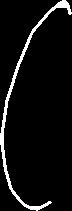

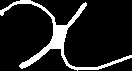

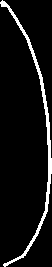

In [90]:
from PIL import Image as im

data = im.fromarray(roilist[0])

print(type(data))

#im.open(data, mode='r')

for i in range(len(roilist)):
    data = im.fromarray(roilist[i])
    display(data)
    data.save('generatedimgs/4thtrychar'+str(i)+'.png')

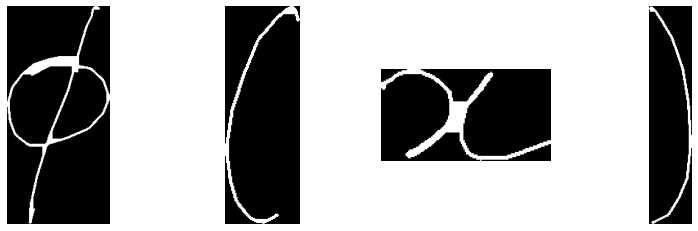

In [91]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(roilist),nrows=1,figure=fig)

for i in range(len(roilist)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(im.fromarray(roilist[i]),cmap="gray")
    plt.savefig("generatedimgs/segmented_characters4thtry.png",dpi=300)

Yay! managed to get it sorted in correct order!

now need to decrease the spacing between the digits

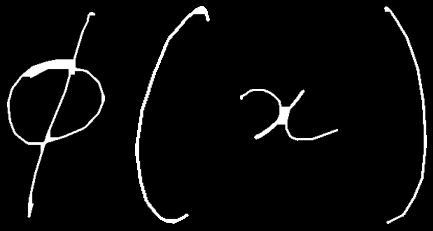

In [114]:
fig = plt.figure(figsize=(8,4))
plt.style.use('dark_background')
fig.set_facecolor('black')
grid = gridspec.GridSpec(ncols=len(roilist),nrows=1,figure=fig)

for i in range(len(roilist)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(im.fromarray(roilist[i]),cmap="gray", ) #aspect='auto'
    plt.savefig("generatedimgs/segmented_characters(7).png",bbox_inches='tight',dpi=500)
    
    #bbox_inches='tight' proved to be quite good


Other configurations/variations

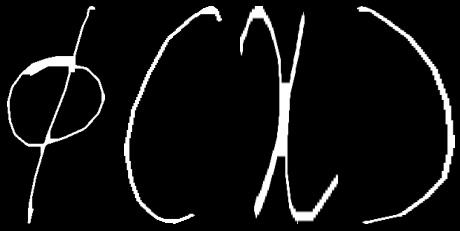

In [115]:
fig = plt.figure(figsize=(8,4))
plt.style.use('dark_background')
fig.set_facecolor('black')
grid = gridspec.GridSpec(ncols=len(roilist),nrows=1,figure=fig)

for i in range(len(roilist)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(im.fromarray(roilist[i]),cmap="gray", aspect='auto') 
    plt.savefig("generatedimgs/segmented_characters(8).png",bbox_inches='tight',dpi=500)
    
    #bbox_inches='tight' proved to be quite good

So trying these different variations on Tesseract

# End of Pre-Processing!


Note from Prof Loke, need try different expressions

# Trying out a New Expression

In [38]:
inputpath = 'CROHME_extractor/data/CROHME_full_v2/CROHME2011_data/CROHME_training/formulaire001-equation015.inkml'
outputpath = 'generatedimgs/test2.png'

In [39]:
inkml2img(inputpath, outputpath, color='#284054')

<ipython-input-10-e80d7ae14dcc>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().get_xaxis().set_visible(False)
<ipython-input-10-e80d7ae14dcc>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().get_yaxis().set_visible(False)
<ipython-input-10-e80d7ae14dcc>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a

<Figure size 432x288 with 0 Axes>

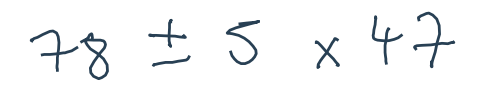

In [40]:
from IPython.display import Image
Image(filename=outputpath)

In [41]:
import cv2
import numpy as np

outputpath = 'generatedimgs/test2.png'

# Load the image
img = cv2.imread(outputpath)

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

cv2.imshow('graycsale image',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

#no change actually hahaa

In [42]:
# smooth the image to avoid noises
gray = cv2.medianBlur(gray,5)

cv2.imshow('smoothed image',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [43]:
thresh = cv2.adaptiveThreshold(gray,255,1,1,11,2)
thresh_color = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

cv2.imshow('thresh',thresh_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

thresh = cv2.adaptiveThreshold(gray,255,1,1,11,2)

thresh_color = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)
cv2.imshow('thresh',thresh_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

# apply some dilation and erosion to join the gaps
thresh = cv2.dilate(thresh,None,iterations = 5)
thresh = cv2.erode(thresh,None,iterations = 5)
cv2.imshow('thresh',thresh_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

#img_nobox = thresh_color.copy()


contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
digitCnts = []

# For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.rectangle(thresh_color,(x,y),(x+w,y+h),(0,255,0),2)
    ## if the contour is sufficiently large, it must be a digit
    if w >= 15:
        digitCnts.append(cnt)

img_wbox = thresh_color.copy()

# Finally show the image
cv2.imshow('img',img)
cv2.imshow('res',thresh_color)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [44]:
# #saving segmented files locally
cv2.imwrite('generatedimgs/segmentedtest2.png', img)

True

In [45]:
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

digitCnts = []
boxes = []

# For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    #print(x,y,x+w,y+h)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    digitCnts.append(cnt)
    
    boxes.append(np.array([x,y,x+w,y+h]))

# Find the contours
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

digitCnts = []

boxes = []

# For each contour, find the bounding rectangle and draw it
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    #print(x,y,x+w,y+h)

    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    digitCnts.append(cnt)

    boxes.append(np.array([x,y,x+w,y+h]))

#print(len(digitCnts))
#
#print(digitCnts[0].shape)


#print(boxes)
#print(len(boxes))

#a1,a2,a3,a4,a5,a6 = boxes

for i in range(len(boxes)):
    newarray = np.stack(boxes, axis=0, out=None)
#print(newarray)


for cnt in digitCnts:   
    x,y,w,h = cv2.boundingRect(cnt)
    # perform non-maximum suppression on the bounding boxes
    pick = non_max_suppression_fast(newarray, 0.3)

print("after applying non-maximum," + str((len(pick))) + "bounding boxes")


img_original = img

img_nms = img.copy()

for (startX, startY, endX, endY) in pick:
    cv2.rectangle(img_nms, (startX, startY), (endX, endY), (0, 255, 0), 2)


after applying non-maximum,7bounding boxes


In [19]:
# # display the images
#cv2.imshow("Original Image", img)
#cv2.imshow("Original Segmentation", img)
#cv2.imshow("After NMS", img_nms)
#cv2.waitKey(0)

27

<!-- <div>
<img src="generatedimgs/segmentednms2.png" width="600"/>
</div> -->